In [14]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

In [15]:
data = pd.read_csv("../data/tables/cog/CyCOG_binary_95_completeness.csv")
data.set_index("name", inplace=True)
mat = data.values

In [16]:
for k in range(2, 12):
    km = KMeans(n_clusters=k)
    km.fit(mat)
    labels = km.labels_
    results = pd.DataFrame([data.index, labels]).T
    results.columns=("Genome", "K-group")
    results.sort_values(["K-group", "Genome"], inplace=True)
    results.to_csv(f"../data/tables/kmeans/{k}-means-allCOGs.csv", index=False)

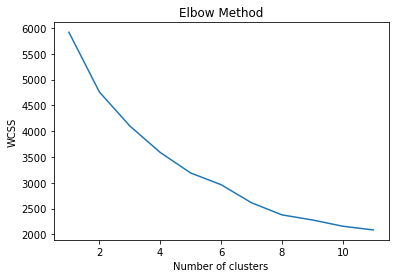

In [18]:
wcss = []
for i in range(1, 12):  # 11 is the number of genera
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(mat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
plot_file = "../data/tables/cog/CyCOG_binary_95_completeness.csv"
plot_table = pd.read_csv(plot_file, index_col="name")

In [ ]:
fig, ax = plt.subplots(figsize=(50, 15))

cmap = mpl.colors.ListedColormap(['w', 'b'])
bounds = [0., 0.5, 1.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax.imshow(plot_table, interpolation='none', cmap=cmap, norm=norm, aspect="auto")
yticks = plt.yticks(range(plot_table.shape[0]), plot_table.index)

# Uncomment this if you wish COG names in the xticks
xticks = plt.xticks(range(plot_table.shape[1]), plot_table.columns, rotation=90)

# Uncomment to save
plt.savefig("../data/plots/CyCOG_presence_absence.png", dpi=300, bbox_inches='tight')

In [53]:
# Reading data into a single df
tables = dict()
for k in (2, 3, 4):
    tables[k] = pd.read_csv(f"../data/tables/kmeans/{k}-means-CyCOGs.csv")
COG_df = tables[2].merge(
    tables[3], on="Genome").merge(
    tables[4], on="Genome")
COG_df.columns=("Genome", "2-means", "3-means", "4-means")

# Translating cluster number into ecological groups
trans = {
    "2-means": {
        0: "Seawater",
        1: "Freshwater/Thermal"
    },
    "3-means": {
        0: "Seawater",
        1: "Symbiont",
        2: "Freshwater/Thermal"
    },
    "4-means": {
        0: "Thermal",
        1: "Seawater",
        2: "Symbiont",
        3: "Freshwater"
    },
}

for k in (2, 3, 4):
    COG_df[f"{k}-means"] = COG_df[f"{k}-means"].apply(lambda n: trans[f"{k}-means"][n])
    
COG_df["Genus"] = COG_df["Genome"].apply(lambda s: s.split()[0])

In [105]:
table2 = COG_df.drop_duplicates(subset=("Genus"))[[
    "Genus", "2-means", "3-means", "4-means"]].copy()


table2.reset_index(inplace=True)
reindex = list(table2["index"])
reindex = reindex[:7] + [65, 85, 90, 77]
table2 = table2.set_index("index").reindex(reindex[::-1])
table2.set_index("Genus", inplace=True)
table2.to_csv("../data/tables/Table_2.csv")